# Importing required packages

In [61]:
# importing regular built in packages
import time
import os
import glob
import urllib as url

# importing required AI/ML packages
import numpy as np
import pandas as pd
import sklearn as sk
import torch
import matplotlib.pyplot as plt
%matplotlib inline

# importing some nlp packages
import nltk
import spacy
import gensim
import gensim.downloader as api
import unicodedata
import re
import string

#glove_embed = api.load("glove-wiki-gigaword-300")
#nlp = spacy.load("en_core_web_sm")
torch.manual_seed(1234)

# 1. Loading and cleaning data

In [62]:
def load_clean(fname):
    '''
    fname: the name of the file to be loaded and cleaned
    '''
    
    ### load raw data section
    data = []
    
    file = open(fname, "r")
    text = file.read()
    file.close()

    data = text.split("\n")
    print("File ", fname, " has been loaded!!")
    print("File contains ",len(data), " number of lines.")
    
    
    ### clean raw data section
    mainlabels, sublabels, questions = [], [], []
    no_punc, word_list = [], []
    
    # iterate through each line
    for line in data:
        words = line.split()
        text = []
        
        # iterate through each word in the line
        for i, w in enumerate(words):
            # collecting all the labels
            if i == 0:
                lab = w.split(':')
                mainlabels.append(lab[0])
                sublabels.append(w)
                continue   
            
            text.append(w.strip())
            
        # join the words to form the text
        full_line = " ".join([w for w in text])
        questions.append(full_line)
        
        # clean up new line
        text = full_line[:-2]
        
        # removing punctuations, forming sentence and split words
        punct = "".join([c for c in string.punctuation if c is not '-'])
        sentence = " ".join([w.lower().strip() for w in text.split()])
        
        rm_punc = "".join([c for c in sentence if c not in punct])
        rm_1char_punc = " ".join([w for w in rm_punc.split() if len(w) > 1])
        words = rm_1char_punc.split()
        
        no_punc.append(rm_1char_punc)
        word_list.append(words)
        
    # convert all the required data into a dataframe for ease of visualization and manipulation
    dataframe = pd.DataFrame({'label': mainlabels, 'inner label': sublabels, 'text': questions,
                             'clean_sentence': no_punc, 'clean_words': word_list})
    
    return dataframe

In [230]:
# loading and cleaning the required data
clean_5500 = load_clean('[input] 5500 training questions.txt')
clean_5500.head()

File  [input] 5500 training questions.txt  has been loaded!!
File contains  5452  number of lines.


,label,inner label,text,clean_sentence,clean_words
0,DESC,DESC:manner,How did serfdom develop in and then leave Russ...,how did serfdom develop in and then leave russia,"[how, did, serfdom, develop, in, and, then, le..."
1,ENTY,ENTY:cremat,What films featured the character Popeye Doyle ?,what films featured the character popeye doyle,"[what, films, featured, the, character, popeye..."
2,DESC,DESC:manner,How can I find a list of celebrities ' real na...,how can find list of celebrities real names,"[how, can, find, list, of, celebrities, real, ..."
3,ENTY,ENTY:animal,What fowl grabs the spotlight after the Chines...,what fowl grabs the spotlight after the chines...,"[what, fowl, grabs, the, spotlight, after, the..."
4,ABBR,ABBR:exp,What is the full form of .com ?,what is the full form of com,"[what, is, the, full, form, of, com]"


# 2. One hot encoding the output label

In [231]:
# function to one hot encode the labels of each question
def onehot_label(df, feature):
    '''
    df: the dataframe being used currently
    feature: the column name for which one hot encoded labels are to be labeled
    '''
    
    # converting labels into arrays
    label = np.array(df[feature]).reshape(-1, 1)
    
    # using the sklearn one hot encoding method
    onehot = sk.preprocessing.OneHotEncoder()
    onehot_label = onehot.fit_transform(label)
    
    print("One hot encoding of labels complete!")
    print("Categories in the one hot encoding: ", onehot.categories_)
    print("Shape of the resulting encoding: ", onehot_label.shape)
    
    # returning the dataframe consisting of the results
    encoded = pd.DataFrame(data=onehot_label.toarray(), columns=onehot.categories_)
    return encoded

In [232]:
# loading up the output encodings
onehot_5500 = onehot_label(clean_5500, 'label')
onehot_5500.head()

One hot encoding of labels complete!
Categories in the one hot encoding:  [array(['ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'NUM'], dtype=object)]
Shape of the resulting encoding:  (5452, 6)


,ABBR,DESC,ENTY,HUM,LOC,NUM
0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0


# 3. Training Word2Vec embeddings for the corpus

In [233]:
# using the gensim function to clean and tokenize the text
clean_5500['gensim_clean'] = clean_5500['text'].apply(lambda x: gensim.utils.simple_preprocess(x))
clean_5500.head()

,label,inner label,text,clean_sentence,clean_words,gensim_clean
0,DESC,DESC:manner,How did serfdom develop in and then leave Russ...,how did serfdom develop in and then leave russia,"[how, did, serfdom, develop, in, and, then, le...","[how, did, serfdom, develop, in, and, then, le..."
1,ENTY,ENTY:cremat,What films featured the character Popeye Doyle ?,what films featured the character popeye doyle,"[what, films, featured, the, character, popeye...","[what, films, featured, the, character, popeye..."
2,DESC,DESC:manner,How can I find a list of celebrities ' real na...,how can find list of celebrities real names,"[how, can, find, list, of, celebrities, real, ...","[how, can, find, list, of, celebrities, real, ..."
3,ENTY,ENTY:animal,What fowl grabs the spotlight after the Chines...,what fowl grabs the spotlight after the chines...,"[what, fowl, grabs, the, spotlight, after, the...","[what, fowl, grabs, the, spotlight, after, the..."
4,ABBR,ABBR:exp,What is the full form of .com ?,what is the full form of com,"[what, is, the, full, form, of, com]","[what, is, the, full, form, of, com]"


In [251]:
# splitting into train test split
#x_tr, x_te, y_tr, y_te = sk.model_selection.train_test_split(clean_5500['gensim_clean'], clean_5500['label'], test_size=0.2, random_state=123)

# training pre-trained word2vec model on our data
#w2v_5500 = gensim.models.Word2Vec(x_tr, size=100, window=2, min_count=2)

In [69]:
# looking at all the words in the trained word2vec model
#w2v_5500.wv.index2word

In [365]:
# saving the word vectors to be used in option 2 post processing word embeddings

# saving the trained pre-trained model
#w2v_5500.save("../option 2 - post processing review/init_trained_wvmodel")

# saving the word vectors
#w2v_5500.wv.save("../option 2 - post processing review/init_trained_wvvectors")

In [396]:
## loading vectors after training the pre-trained word2vec model

#w2v_5500_model = gensim.models.Word2Vec.load('ques_embed\init_trained_wvmodel')
w2v_5500_vectors = gensim.models.KeyedVectors.load('ques_embed\init_trained_wvvectors')

w2v_5500_vectors['and']

array([-0.03767836, -0.14755373, -0.25785303,  0.3687091 , -0.17937383,
       -0.01613118,  0.757773  , -0.10143571,  0.30006182,  0.17047554,
        0.8188774 , -0.1041642 , -0.353399  ,  0.625181  , -0.69155914,
        0.20440276,  0.38170278, -0.04678288,  0.4412677 , -0.4381382 ,
       -0.26271564, -0.44058645, -0.23022822, -0.07919661, -0.46207285,
       -0.43104732,  0.2878037 , -0.26285115,  0.5273679 ,  0.03374153,
       -0.10948228, -0.00717028,  0.0291024 , -0.16392864,  0.08129709,
       -0.1302403 ,  0.5638297 , -0.6421315 ,  0.11053333, -0.20486686,
        0.25215313, -0.20635764,  0.01797247,  0.08350865, -0.3166323 ,
        0.16504246, -0.01690575,  0.78841066, -0.10319585, -0.15116751,
        0.13857701,  0.01183684,  0.30259028,  0.5597777 , -0.4233133 ,
       -0.10353647,  0.00557435,  0.64496464,  0.05992203,  0.48058787,
       -0.04977149,  0.36644852,  0.3276535 ,  0.01343803,  0.49237624,
        0.17227092,  0.29820964, -0.33770066, -0.15252665, -0.42

# 4. Helper Functions to training the LSTM

In [385]:
def split_data(input_data, output_data, sp):
    '''
    input_data: the series containing the data to be used as input
    output_data: the one hot encoded output
    sp[0]: the split fraction to divide training and test data
    sp[1]: the split fraction to divide training and validated data
    '''
    
    x_tr, x_te, y_tr, y_te = sk.model_selection.train_test_split(input_data, output_data, test_size=sp[0], random_state=3)
    x_tr, x_va, y_tr, y_va = sk.model_selection.train_test_split(x_tr, y_tr, test_size=sp[1], random_state=123)
    
    print("Shape of training set: ", x_tr.shape, y_tr.shape)
    print("Shape of validation set: ", x_va.shape, y_va.shape)
    print("Shape of testing set: ", x_te.shape, y_te.shape)
    
    return (x_tr, y_tr), (x_va, y_va), (x_te, y_te)


# extracting the text into a group of tensors
def text_tensor(text, embed):
    '''
    text: the input text consisting of a list of words
    embed: the pre trained gensim embedding after being trained on the input data
    '''
    
    # cleaning the text by gensim procedures
    clean = gensim.utils.simple_preprocess(text)
    
    # creating a mean vector of the sentence in case the specific word is not encoded
    mean_embed = torch.mean(torch.tensor([embed[w] for w in clean if w in embed.wv.index2word]), dim=0)
    
    # collect the respective tensors
    samp = []
    for w in clean:
        if w in embed.wv.index2word:
            samp.append(torch.tensor(embed[w]))
        else:
            samp.append(torch.tensor(mean_embed))
            
    # combine the tensors into a single batch
    torch_text = torch.cat([torch.tensor(s) for s in samp]).reshape(len(clean), 1, -1)
    return torch_text

In [386]:
# saving a trained model
def saving(model, loc):
    '''
    model: the trained model to be saved
    loc: the name of the model (can be used together with /dir/name)
    '''
    torch.save(model, loc)
    return


# loading a trained model
def loading(model, loc):
    '''
    model: the newly initialised model (should be the same architecture of the model to be loaded)
    loc: the name of the model (can be used together with /dir/name)
    '''
    # model must be initialised with same class as saved
    model = torch.load(loc)
    return model

# 5. Building the LSTM model

In [387]:
class gensim_lstm(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_dim, hidden_layers, dropout):
        super(gensim_lstm, self).__init__()
        '''
        input_dim: the size of the input vector (a single word in a sentence)
        output_dim: the size of the expected output layer nodes
        hidden_dim: the size of the hidden layer nodes
        hidden_layers: the number of hidden lstm layers
        dropout: fraction of lstm results that are to be dropped
        '''
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.hidden_layers = hidden_layers
        self.dropout = dropout
        
        self.lstm = torch.nn.LSTM(self.input_dim, self.hidden_dim, self.hidden_layers, dropout=self.dropout)
        self.dense = torch.nn.Linear(self.hidden_dim * 2, self.output_dim)
        self.sigm = torch.nn.Sigmoid()
        

    def forward(self, vector, hid):
        '''
        vector: the input vector of the entire sentence
        hid: the initialized hidden and cell state
        '''
        
        # passing input and hid into lstm per each input vector
        for vec in vector:
            output, hid = self.lstm(vec.reshape(1, 1, -1), hid)
            
        # combining the last output and hidden
        combined = torch.cat((output[-1, :, :], hid[0][-1, :, :]), dim=1)
        # apply the combined into a dense layer
        final_output = self.dense(combined)
        # passing the final output through the sigmoid activation
        active_output = self.sigm(final_output)
        return active_output
        
        
    def init_hidden(self):
        # initializing the hidden and cell state
        hidden = (torch.zeros(self.hidden_layers * self.hidden_dim).reshape(self.hidden_layers, 1, -1), 
                  torch.zeros(self.hidden_layers * self.hidden_dim).reshape(self.hidden_layers, 1, -1))
        return hidden

In [388]:
# hyperparameters
def set_model(hidden_dim, hidden_layers, dropout):
    '''
    hidden_dim: the size of the lstm hidden layer
    hidden_layers: the number of lstm hidden layers
    dropout: the fraction of lstm results to be dropped
    '''
    
    input_dim = 100
    output_dim = 6

    # instantiate the model
    model = gensim_lstm(input_dim, output_dim, hidden_dim, hidden_layers, dropout)
    
    print("Model Architecture: ")
    print(model)
    return model

set_model(1000, 10, 0.5)

Model Architecture: 
gensim_lstm(
  (lstm): LSTM(100, 1000, num_layers=10, dropout=0.5)
  (dense): Linear(in_features=2000, out_features=6, bias=True)
  (sigm): Sigmoid()
)


gensim_lstm(
  (lstm): LSTM(100, 1000, num_layers=10, dropout=0.5)
  (dense): Linear(in_features=2000, out_features=6, bias=True)
  (sigm): Sigmoid()
)

In [ ]:
'''
# testing out the built model
samp1 = text_tensor(clean_5500['text'][0], w2v_5500)
samp2 = text_tensor(clean_5500['text'][1], w2v_5500)

m1 = set_model(200, 2, 0.5)
h = m1.init_hidden()

p = m1(i, h)
    
p
'''

# 6. Training and Validating the model

In [389]:
def train_valid(model, train, valid, epochs, clip, name):
    '''
    model: the newly initialized model
    train: the training dataset (train[0] is input train[1] is output)
    valid: the validation dataset (valid[0] is input valid[1] is output)
    epochs: the number of epochs to train the model
    clip: the norm value of when to clip the gradients
    name: the name of the model to be used in saving
    '''
    
    # loss function
    loss_fn = torch.nn.BCELoss()
    
    # set optimizer
    optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    
    # collecting and averaging the loss
    train_losses, train_avg_loss = [], []
    valid_losses, valid_avg_loss = [], []
    train_acc, valid_acc = [], []
    
    # iterating through the epochs
    for i in range(epochs):
        
        tic = time.time()

        # setting model to train mode
        model.train()
        train_actual_class, train_predict_class = [], []
        
        # iterating through the training data
        for vec in range(len(train[0])):
            
            # initialize the hidden and cell state
            hidden = model.init_hidden()
            
            # zeroing the gradients
            model.zero_grad()

            # setting up the input and output
            inp = text_tensor(train[0].iloc[vec], w2v_5500_vectors)
            out = torch.tensor(train[1].iloc[vec], dtype=torch.float).reshape(1, -1)
            
            #for vector in inp:
            pred = model(inp, hidden)

            # calculating the loss and back propagate
            loss = loss_fn(pred, out)
            train_losses.append(loss.item())
            loss.backward()
            
            # `clip_grad_norm` helps prevent the exploding gradient problem
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            
            # optimizing on the loss
            optim.step()

            train_actual_class.append(torch.argmax(out))
            train_predict_class.append(torch.argmax(pred).detach())
            
            if (vec+1) % 500 == 0:
                print("Training document ", vec+1, " / ", len(train[0]), "...")

        train_accuracy = sk.metrics.accuracy_score(train_actual_class, train_predict_class)
        train_acc.append(train_accuracy)
        train_avg_loss.append(sum(train_losses) / len(train_losses))
        


        #### setting model to evaluate mode
        model.eval()
        valid_actual_class, valid_predict_class = [], []

        # iterating through the training data
        for vec in range(len(valid[0])):
            
            # initialize the hidden and cell state
            hidden = model.init_hidden()

            # setting up the input and output
            inp = text_tensor(valid[0].iloc[vec], w2v_5500_vectors)
            out = torch.tensor(valid[1].iloc[vec], dtype=torch.float).reshape(1, -1)

            #for vector in inp:
            pred = model(inp, hidden)

            # calculating the loss
            loss = loss_fn(pred, out)
            valid_losses.append(loss.item())

            valid_actual_class.append(torch.argmax(out))
            valid_predict_class.append(torch.argmax(pred).detach())

            if (vec+1) % 500 == 0:
                print("Validating document ", vec+1, " / ", len(valid[0]), "...")


        valid_avg_loss.append(sum(valid_losses) / len(valid_losses))
        valid_accuracy = sk.metrics.accuracy_score(valid_actual_class, valid_predict_class)
        valid_acc.append(valid_accuracy)
        confusion = sk.metrics.confusion_matrix(valid_actual_class, valid_predict_class)

        print("\nTrain Loss: ", train_avg_loss[-1])
        print("Validation Loss: ", valid_avg_loss[-1])
        print("Train Accuracy: ", train_accuracy)
        print("Validation Accuracy: ", valid_accuracy)

        print("Confusion matrix:")
        print(confusion)

        title = "Confusion at epoch: " + str(i + 1)
        plt.title(title)
        plt.imshow(confusion)
        plt.show()
        
        
        if (i+1) % 100 == 0:
            mod_name = name + str(i+1)
            location = "ques_lstm/" + mod_name
            saving(model, location)
            print("Saving the model at epoch: ", i + 1, " as ", mod_name)
        

        print("Epoch ", i + 1, " is complete!")
        print("Complete in ", (time.time() - tic), " seconds\n\n")

    
    plt.figure(figsize=(10, 5))
    plt.title("Plotting the train loss vs. validation loss")
    plt.plot([i for i in range(epochs)], train_avg_loss)
    plt.plot([i for i in range(epochs)], valid_avg_loss)
    
    plt.figure(figsize=(10, 5))
    plt.title("Plotting the train accuracy vs. validation accuracy")
    plt.plot([i for i in range(epochs)], train_acc)
    plt.plot([i for i in range(epochs)], valid_acc)
    
    res = pd.DataFrame({'train_accuracy': train_acc, 'valid_accuracy': valid_acc, 'train_avg_loss': train_avg_loss,
                       'valid_avg_loss': valid_avg_loss,})
    
    return model, res

Shape of training set:  (3488,) (3488, 6)
Shape of validation set:  (873,) (873, 6)
Shape of testing set:  (1091,) (1091, 6)
Model Architecture: 
gensim_lstm(
  (lstm): LSTM(100, 300, num_layers=3, dropout=0.7)
  (dense): Linear(in_features=600, out_features=6, bias=True)
  (sigm): Sigmoid()
)


C:\Users\sunny\Anaconda3\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type gensim_lstm. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\sunny\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
C:\Users\sunny\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
C:\Users\sunny\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\sunny\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use source

Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.4252344869609085
Validation Loss:  0.41969587214350834
Train Accuracy:  0.24913990825688073
Validation Accuracy:  0.30584192439862545
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 101  84   1   0   0]
 [  0  47 140  17   0   0]
 [  0  61 120  26   0   0]
 [  0  32  84   4   0   0]
 [  0  34  96   7   0   0]]


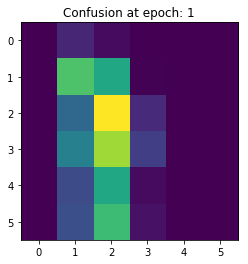

Epoch  1  is complete!
Complete in  569.7329313755035  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.42010897073807696
Validation Loss:  0.41477150161497783
Train Accuracy:  0.2806766055045872
Validation Accuracy:  0.29553264604810997
Confusion matrix:
[[  0  19   0   0   0   0]
 [  0 176   2   8   0   0]
 [  0 139  11  54   0   0]
 [  0 120  16  71   0   0]
 [  0  97   4  19   0   0]
 [  0 120   9   8   0   0]]


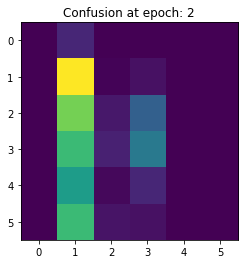

Epoch  2  is complete!
Complete in  498.5277338027954  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.41629193784551205
Validation Loss:  0.4142929800068117
Train Accuracy:  0.29759174311926606
Validation Accuracy:  0.32646048109965636
Confusion matrix:
[[  0  15   0   0   0   4]
 [  0 101   0  11   0  74]
 [  0  46   0  62   0  96]
 [  0  46   0  88   0  73]
 [  0  31   0  22   0  67]
 [  0  24   0  17   0  96]]


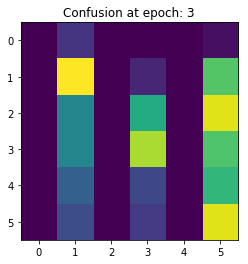

Epoch  3  is complete!
Complete in  559.5023684501648  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.4144252882845173
Validation Loss:  0.4132630463949867
Train Accuracy:  0.29329128440366975
Validation Accuracy:  0.3241695303550974
Confusion matrix:
[[  0  19   0   0   0   0]
 [  0 173   0  13   0   0]
 [  0 120   0  74   0  10]
 [  0  93   0  96   0  18]
 [  0  76   0  27   0  17]
 [  0  96   0  27   0  14]]


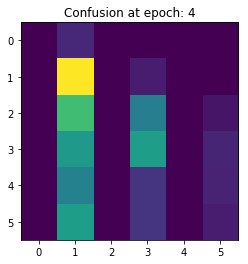

Epoch  4  is complete!
Complete in  643.3268830776215  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.41310485495770255
Validation Loss:  0.41229806868924856
Train Accuracy:  0.3073394495412844
Validation Accuracy:  0.30469644902634596
Confusion matrix:
[[  0  19   0   0   0   0]
 [  0 172   0  12   0   2]
 [  0 123  11  57   0  13]
 [  0  93  20  69   0  25]
 [  0  76   5  19   0  20]
 [  0 104   4  15   0  14]]


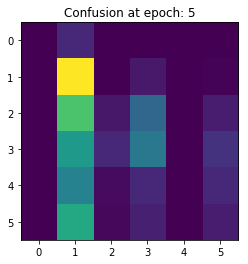

Epoch  5  is complete!
Complete in  739.7209129333496  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.41159868065417504
Validation Loss:  0.41082770507263516
Train Accuracy:  0.3033256880733945
Validation Accuracy:  0.3207331042382589
Confusion matrix:
[[  0  19   0   0   0   0]
 [  0 167   8   4   0   7]
 [  0 114  64   9   0  17]
 [  0  81  66  28   0  32]
 [  0  67  24   0   0  29]
 [  0  95   9  12   0  21]]


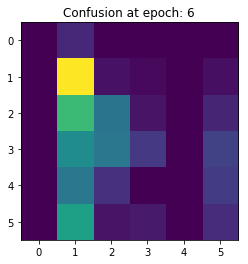

Epoch  6  is complete!
Complete in  751.7670781612396  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.40962853458491677
Validation Loss:  0.4078022472156848
Train Accuracy:  0.3334288990825688
Validation Accuracy:  0.38831615120274915
Confusion matrix:
[[  0  19   0   0   0   0]
 [  0 144   1  12   4  25]
 [  0 114   5  80   2   3]
 [  0  77   5 105   3  17]
 [  0  29  10  37  42   2]
 [  0  72   1  21   0  43]]


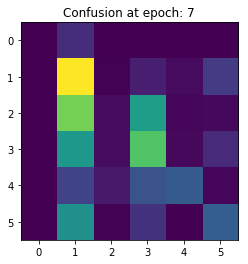

Epoch  7  is complete!
Complete in  612.6248860359192  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.40633106886478915
Validation Loss:  0.40663400316346365
Train Accuracy:  0.38188073394495414
Validation Accuracy:  0.35853379152348225
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 167   7   4   6   2]
 [  0 107  32  28  37   0]
 [  0  85  36  58  28   0]
 [  0  39  22   2  56   1]
 [  0  86  12  21  18   0]]


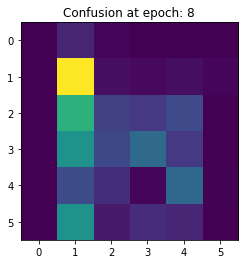

Epoch  8  is complete!
Complete in  624.6172840595245  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.40131611806987655
Validation Loss:  0.40025843435392755
Train Accuracy:  0.43061926605504586
Validation Accuracy:  0.4627720504009164
Confusion matrix:
[[ 0 17  2  0  0  0]
 [ 0 97 20  7 22 40]
 [ 0 64 97 14 24  5]
 [ 0 45 65 53 19 25]
 [ 0 15 34  1 68  2]
 [ 0 15 17 12  4 89]]


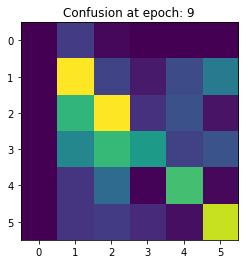

Epoch  9  is complete!
Complete in  620.9947626590729  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3967964517167241
Validation Loss:  0.3952407521435741
Train Accuracy:  0.4501146788990826
Validation Accuracy:  0.4524627720504009
Confusion matrix:
[[  0  19   0   0   0   0]
 [  0 128  10   3   4  41]
 [  0 107  77  14   1   5]
 [  0  58  63  58   1  27]
 [  0  27  48   0  43   2]
 [  0  26  10  12   0  89]]


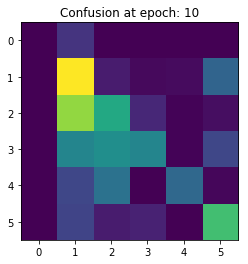

Epoch  10  is complete!
Complete in  601.5859694480896  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3918044287566894
Validation Loss:  0.3884431980942583
Train Accuracy:  0.4833715596330275
Validation Accuracy:  0.5269186712485682
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0  77  39   3  24  43]
 [  0  38 122  13  25   6]
 [  0  10  71 107  16   3]
 [  0   5  52   0  61   2]
 [  0   5  26   8   5  93]]


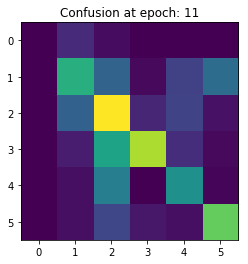

Epoch  11  is complete!
Complete in  698.1475899219513  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3871722833186953
Validation Loss:  0.38252193586917366
Train Accuracy:  0.48795871559633025
Validation Accuracy:  0.5463917525773195
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0  94  39   2   4  47]
 [  0  42 139  10   4   9]
 [  0  11  84 100   1  11]
 [  0   9  65   0  44   2]
 [  0   7  29   1   0 100]]


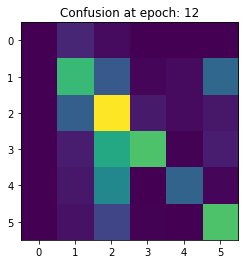

Epoch  12  is complete!
Complete in  523.7123034000397  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.38298978730098937
Validation Loss:  0.37710749572071567
Train Accuracy:  0.49684633027522934
Validation Accuracy:  0.5395189003436426
Confusion matrix:
[[  0  16   3   0   0   0]
 [  0  79  54   2  17  34]
 [  0  27 157   8   1  11]
 [  0   5  91  99   0  12]
 [  0   5  70   0  43   2]
 [  0  11  32   1   0  93]]


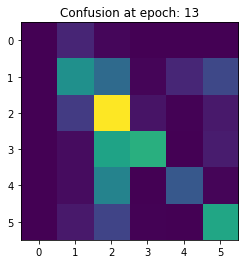

Epoch  13  is complete!
Complete in  583.5524227619171  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3790224857007381
Validation Loss:  0.3727835508934331
Train Accuracy:  0.5045871559633027
Validation Accuracy:  0.5601374570446735
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 135  30   2   4  15]
 [  0  61 123  15   3   2]
 [  0  12  79 107   6   3]
 [  0  16  59   1  43   1]
 [  0  31  22   3   0  81]]


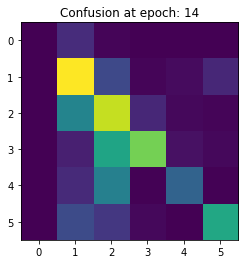

Epoch  14  is complete!
Complete in  612.9695007801056  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3755613412255922
Validation Loss:  0.3683148002158815
Train Accuracy:  0.5157683486238532
Validation Accuracy:  0.5555555555555556
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0  97  36   2   4  47]
 [  0  48 118  32   1   5]
 [  0  15  58 127   0   7]
 [  0   7  64   4  43   2]
 [  0   9  26   2   0 100]]


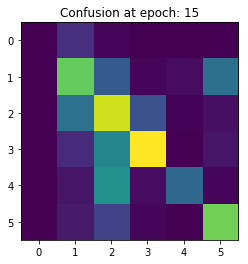

Epoch  15  is complete!
Complete in  614.7011499404907  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.37231120737115553
Validation Loss:  0.3641784268585286
Train Accuracy:  0.5071674311926605
Validation Accuracy:  0.5441008018327605
Confusion matrix:
[[  0  16   3   0   0   0]
 [  0  80  35   2  22  47]
 [  0  47 120  30   1   6]
 [  0  11  60 133   0   3]
 [  0   8  62   6  42   2]
 [  0  11  24   2   0 100]]


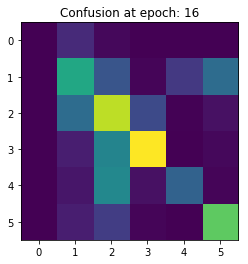

Epoch  16  is complete!
Complete in  536.3231601715088  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3693660217062122
Validation Loss:  0.3610040111385804
Train Accuracy:  0.518348623853211
Validation Accuracy:  0.5486827033218786
Confusion matrix:
[[  0  16   3   0   0   0]
 [  0 111  31   2  22  20]
 [  0  47 137  14   1   5]
 [  0   9  87 103   0   8]
 [  0  10  64   1  43   2]
 [  0  27  24   1   0  85]]


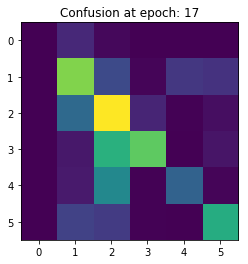

Epoch  17  is complete!
Complete in  619.1617906093597  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3664641181603767
Validation Loss:  0.358061630305007
Train Accuracy:  0.5235091743119266
Validation Accuracy:  0.5441008018327605
Confusion matrix:
[[  0  13   6   0   0   0]
 [  0  83  50  11   4  38]
 [  0  29 151  20   1   3]
 [  0   6  85 115   0   1]
 [  0   5  69   4  42   0]
 [  0   4  32  17   0  84]]


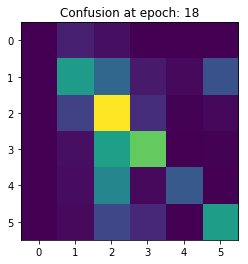

Epoch  18  is complete!
Complete in  610.4409513473511  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.36371047825004615
Validation Loss:  0.35527608029230573
Train Accuracy:  0.5200688073394495
Validation Accuracy:  0.5337915234822451
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 116  17   2   4  47]
 [  0  85  86  27   1   5]
 [  0  18  65 121   0   3]
 [  0  22  52   1  43   2]
 [  0  24  11   2   0 100]]


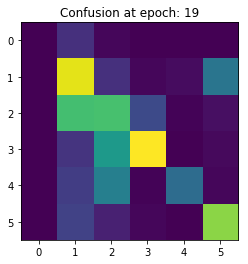

Epoch  19  is complete!
Complete in  619.0706238746643  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3610318398841828
Validation Loss:  0.35254242043963685
Train Accuracy:  0.5358371559633027
Validation Accuracy:  0.5567010309278351
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0  97  36   2   4  47]
 [  0  36 144  12   1  11]
 [  0  11  82 102   0  12]
 [  0   6  68   1  43   2]
 [  0   8  27   2   0 100]]


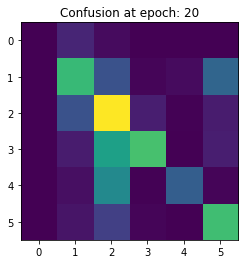

Epoch  20  is complete!
Complete in  621.447835445404  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.35842921362252056
Validation Loss:  0.3499649157898694
Train Accuracy:  0.5438646788990825
Validation Accuracy:  0.5486827033218786
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 107  26   2   4  47]
 [  0  63 121  15   1   4]
 [  0  18  78 108   0   3]
 [  0  22  53   1  43   1]
 [  0  18  18   1   0 100]]


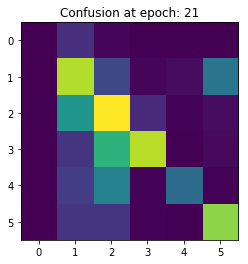

Epoch  21  is complete!
Complete in  784.6961948871613  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.35606441340653133
Validation Loss:  0.3477423982181769
Train Accuracy:  0.5415711009174312
Validation Accuracy:  0.5211912943871707
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 150  18   1   6  11]
 [  0  91  45  23  42   3]
 [  0  25  27 112  35   8]
 [  0  21  32   1  65   1]
 [  0  40  11   2   1  83]]


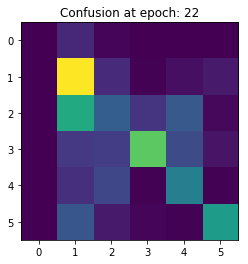

Epoch  22  is complete!
Complete in  663.3414881229401  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.35397945445774226
Validation Loss:  0.35028148442006435
Train Accuracy:  0.5364105504587156
Validation Accuracy:  0.32989690721649484
Confusion matrix:
[[  0  13   6   0   0   0]
 [  0 109  66   4   0   7]
 [  0  35 160   8   0   1]
 [  0  36 148  14   0   9]
 [  0  46  70   2   0   2]
 [  0  24 107   1   0   5]]


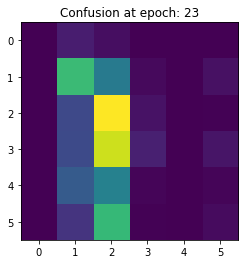

Epoch  23  is complete!
Complete in  733.2623851299286  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.35270468358245505
Validation Loss:  0.3488736433697082
Train Accuracy:  0.5160550458715596
Validation Accuracy:  0.5223367697594502
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0  97  36   2   5  46]
 [  0  50 101  32  18   3]
 [  0  16  51 126  13   1]
 [  0  11  49   6  54   0]
 [  0  12  27  20   0  78]]


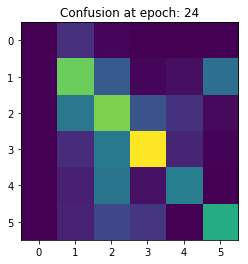

Epoch  24  is complete!
Complete in  791.6814668178558  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.35182287444284
Validation Loss:  0.34746657043708784
Train Accuracy:  0.5045871559633027
Validation Accuracy:  0.5670103092783505
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 139  24   2   4  17]
 [  0  59 124  10   2   9]
 [  0  17  78 101   1  10]
 [  0  13  61   1  43   2]
 [  0  31  17   1   0  88]]


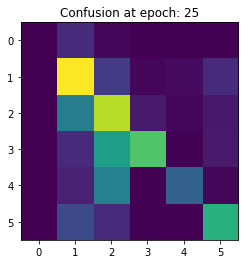

Epoch  25  is complete!
Complete in  686.3734307289124  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3501237497690678
Validation Loss:  0.3459127114367668
Train Accuracy:  0.5455848623853211
Validation Accuracy:  0.5463917525773195
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0  93  28   0  22  43]
 [  0  50 145   3   1   5]
 [  0  14  93  96   1   3]
 [  0  12  63   0  43   2]
 [  0  15  22   0   0 100]]


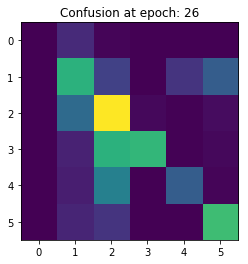

Epoch  26  is complete!
Complete in  667.7813317775726  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3483255059914937
Validation Loss:  0.34717834306893613
Train Accuracy:  0.551605504587156
Validation Accuracy:  0.43757159221076747
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 126  32   0  22   6]
 [  0  59 107  26   4   8]
 [  0  29  86  41   3  48]
 [  0  10  59   7  43   1]
 [  0  47  23   2   0  65]]


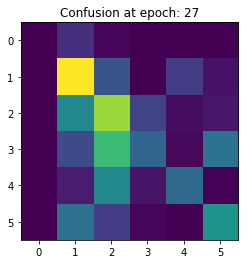

Epoch  27  is complete!
Complete in  701.4947693347931  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3466769836193392
Validation Loss:  0.3449464044207484
Train Accuracy:  0.5581995412844036
Validation Accuracy:  0.5922107674684994
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 118  46   3   9  10]
 [  0  34 129  37   1   3]
 [  0   8  59 137   0   3]
 [  0   5  58  12  43   2]
 [  0  18  27   2   0  90]]


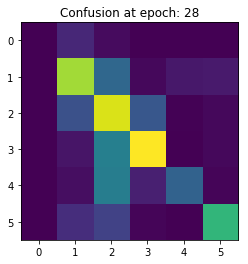

Epoch  28  is complete!
Complete in  663.9106440544128  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.34510934304554036
Validation Loss:  0.3430025252479808
Train Accuracy:  0.5533256880733946
Validation Accuracy:  0.5750286368843069
Confusion matrix:
[[  0  12   7   0   0   0]
 [  0 121  43   3  15   4]
 [  0  26 110  40  19   9]
 [  0   6  41 142  11   7]
 [  0   6  36  14  62   2]
 [  0  42  24   2   2  67]]


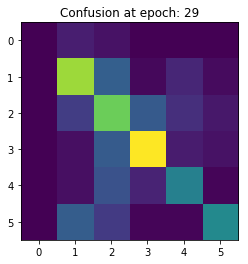

Epoch  29  is complete!
Complete in  746.3248937129974  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3436258549921493
Validation Loss:  0.3413804324186313
Train Accuracy:  0.5536123853211009
Validation Accuracy:  0.5624284077892325
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 103  35   3   4  41]
 [  0  44 106  39  10   5]
 [  0  11  53 132   8   3]
 [  0  10  50   8  50   2]
 [  0  17  18   2   0 100]]


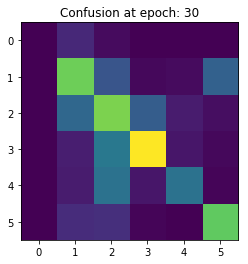

Epoch  30  is complete!
Complete in  752.5611600875854  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3421404494340956
Validation Loss:  0.33973036391581646
Train Accuracy:  0.5650802752293578
Validation Accuracy:  0.5807560137457045
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 119  49   2   5  11]
 [  0  33 120  37  11   3]
 [  0   6  53 130  10   8]
 [  0   5  53   6  55   1]
 [  0  22  30   2   0  83]]


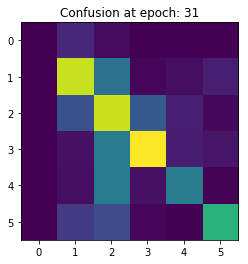

Epoch  31  is complete!
Complete in  745.3616049289703  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3407212115445203
Validation Loss:  0.33851231579733376
Train Accuracy:  0.5650802752293578
Validation Accuracy:  0.5624284077892325
Confusion matrix:
[[  0  16   3   0   0   0]
 [  0 139  36   2   5   4]
 [  0  35 119  23  19   8]
 [  0  13  52 115  20   7]
 [  0   7  53   3  56   1]
 [  0  47  26   2   0  62]]


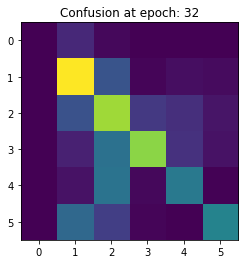

Epoch  32  is complete!
Complete in  628.1725797653198  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.33949523838610907
Validation Loss:  0.3371917037059062
Train Accuracy:  0.5616399082568807
Validation Accuracy:  0.5876288659793815
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 129  24   2   6  25]
 [  0  54  95  28  21   6]
 [  0  14  44 126  14   9]
 [  0  14  28   7  69   2]
 [  0  25  15   2   1  94]]


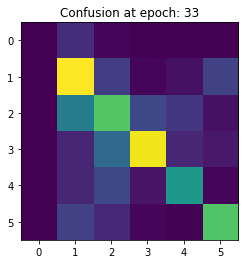

Epoch  33  is complete!
Complete in  637.65420794487  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.338200394251707
Validation Loss:  0.33544729733147227
Train Accuracy:  0.5650802752293578
Validation Accuracy:  0.6071019473081328
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 142  31   2   5   6]
 [  0  46  89  34  34   1]
 [  0  12  39 138  17   1]
 [  0  11  30  10  69   0]
 [  0  25  14   3   3  92]]


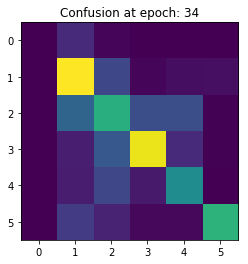

Epoch  34  is complete!
Complete in  613.0877597332001  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.33687099933997156
Validation Loss:  0.3343765150103901
Train Accuracy:  0.573394495412844
Validation Accuracy:  0.565864833906071
Confusion matrix:
[[  0  14   5   0   0   0]
 [  0 139  34   2   9   2]
 [  0  48 101  36  18   1]
 [  0  11  51 127  13   5]
 [  0  13  30  10  66   1]
 [  0  55  19   2   0  61]]


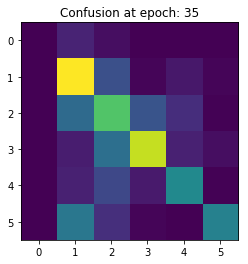

Epoch  35  is complete!
Complete in  635.8635387420654  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.33564426512592344
Validation Loss:  0.3338843055126684
Train Accuracy:  0.564506880733945
Validation Accuracy:  0.5063001145475372
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 151  18   1  11   5]
 [  0  87  54   9  46   8]
 [  0  29  29  98  45   6]
 [  0  17  25   1  76   1]
 [  0  61  11   1   1  63]]


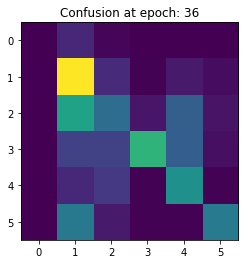

Epoch  36  is complete!
Complete in  704.2459855079651  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3344255876321226
Validation Loss:  0.3326608767924758
Train Accuracy:  0.5831422018348624
Validation Accuracy:  0.581901489117984
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 128  50   2   4   2]
 [  0  32 112  34  17   9]
 [  0   7  45 133  10  12]
 [  0   5  38  11  64   2]
 [  0  34  30   2   0  71]]


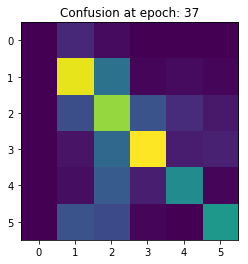

Epoch  37  is complete!
Complete in  652.9771676063538  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3332692135548567
Validation Loss:  0.3316018513580684
Train Accuracy:  0.5814220183486238
Validation Accuracy:  0.572737686139748
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 135  42   2   5   2]
 [  0  33 120  23  22   6]
 [  0   8  54 114  22   9]
 [  0   4  41   4  69   2]
 [  0  46  27   2   0  62]]


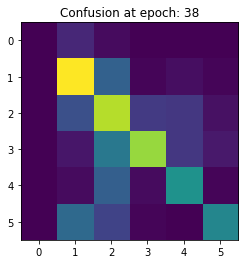

Epoch  38  is complete!
Complete in  644.2552053928375  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.33210435197310173
Validation Loss:  0.3303760911854434
Train Accuracy:  0.5797018348623854
Validation Accuracy:  0.5933562428407789
Confusion matrix:
[[  0  13   6   0   0   0]
 [  0 114  49   1   9  13]
 [  0  30  96  29  47   2]
 [  0   5  37 131  31   3]
 [  0   4  28   8  79   1]
 [  0   5  27   2   5  98]]


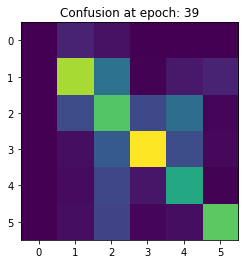

Epoch  39  is complete!
Complete in  601.0503633022308  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.33107306113287005
Validation Loss:  0.32912478235281256
Train Accuracy:  0.5831422018348624
Validation Accuracy:  0.6105383734249714
Confusion matrix:
[[  0  14   5   0   0   0]
 [  0 131  39   2   5   9]
 [  0  29 114  26  32   3]
 [  0   7  49 114  29   8]
 [  0   6  35   1  76   2]
 [  0  12  24   2   1  98]]


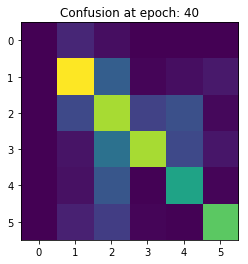

Epoch  40  is complete!
Complete in  494.64256596565247  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3301028404581133
Validation Loss:  0.32785397704224917
Train Accuracy:  0.5908830275229358
Validation Accuracy:  0.5956471935853379
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 142  32   2   7   3]
 [  0  46  93  33  30   2]
 [  0  10  41 127  23   6]
 [  0   8  31   7  73   1]
 [  0  30  19   2   1  85]]


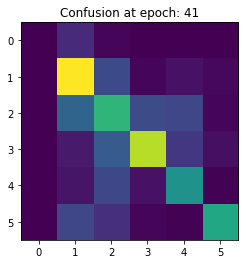

Epoch  41  is complete!
Complete in  492.86714792251587  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3291097104154621
Validation Loss:  0.3270903279111814
Train Accuracy:  0.5960435779816514
Validation Accuracy:  0.5807560137457045
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 140  38   1   5   2]
 [  0  33 131  21  16   3]
 [  0   6  72 110  11   8]
 [  0   6  46   1  65   2]
 [  0  52  20   2   2  61]]


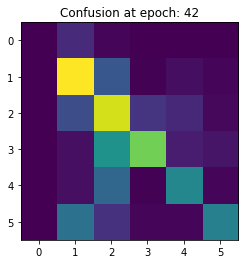

Epoch  42  is complete!
Complete in  546.1735424995422  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3280525429768283
Validation Loss:  0.32573895911932255
Train Accuracy:  0.5994839449541285
Validation Accuracy:  0.6219931271477663
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 145  31   2   5   3]
 [  0  41 106  35  21   1]
 [  0  11  47 130  18   1]
 [  0  11  30   8  71   0]
 [  0  26  14   2   4  91]]


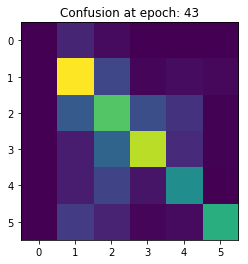

Epoch  43  is complete!
Complete in  627.5584869384766  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.32703511174218064
Validation Loss:  0.32451626386802673
Train Accuracy:  0.5963302752293578
Validation Accuracy:  0.6151202749140894
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 148  27   2   4   5]
 [  0  53  98  37  15   1]
 [  0  13  49 132  12   1]
 [  0  12  33  13  62   0]
 [  0  19  17   3   1  97]]


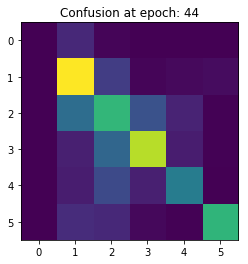

Epoch  44  is complete!
Complete in  617.5057747364044  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.32596025829077085
Validation Loss:  0.32337525704296194
Train Accuracy:  0.6055045871559633
Validation Accuracy:  0.6105383734249714
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 125  37   2  13   9]
 [  0  32 107  31  33   1]
 [  0   5  46 129  26   1]
 [  0   6  34   7  73   0]
 [  0  10  22   2   4  99]]


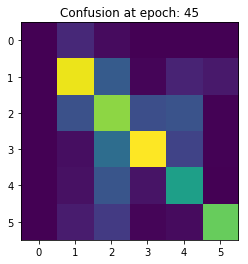

Epoch  45  is complete!
Complete in  589.9319958686829  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.324886333801672
Validation Loss:  0.32216481434305316
Train Accuracy:  0.6106651376146789
Validation Accuracy:  0.6162657502863689
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 145  27   3   4   7]
 [  0  58  96  40   8   2]
 [  0  16  44 139   7   1]
 [  0  12  34  13  60   1]
 [  0  21  15   3   0  98]]


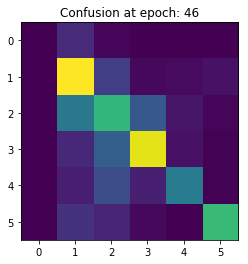

Epoch  46  is complete!
Complete in  607.7184100151062  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.32403847819408055
Validation Loss:  0.3211987903115011
Train Accuracy:  0.6034977064220184
Validation Accuracy:  0.6357388316151202
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 142  34   3   4   3]
 [  0  32 116  36  17   3]
 [  0   8  51 131   9   8]
 [  0   7  35   9  67   2]
 [  0  11  23   2   2  99]]


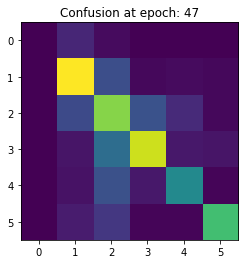

Epoch  47  is complete!
Complete in  502.822562456131  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3230974151932626
Validation Loss:  0.3203184414722779
Train Accuracy:  0.6146788990825688
Validation Accuracy:  0.6048109965635738
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 126  33   3  22   2]
 [  0  40 105  42  16   1]
 [  0   8  50 138  10   1]
 [  0   7  34  15  64   0]
 [  0  14  22   2   4  95]]


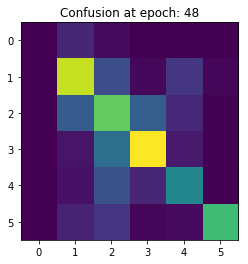

Epoch  48  is complete!
Complete in  593.4047439098358  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3220948608764672
Validation Loss:  0.31919153893260993
Train Accuracy:  0.6221330275229358
Validation Accuracy:  0.6288659793814433
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 144  30   1   6   5]
 [  0  39 116  20  27   2]
 [  0   8  61 118  19   1]
 [  0  10  31   4  74   1]
 [  0  18  16   2   4  97]]


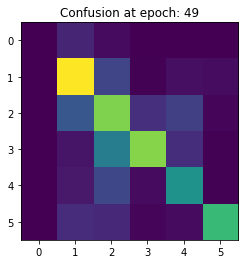

Epoch  49  is complete!
Complete in  624.9560678005219  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3211674452966713
Validation Loss:  0.31823733464885134
Train Accuracy:  0.6189793577981652
Validation Accuracy:  0.6208476517754868
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 127  42   3   4  10]
 [  0  32 112  41  17   2]
 [  0   7  47 142  10   1]
 [  0   7  34  13  65   1]
 [  0  12  26   3   0  96]]


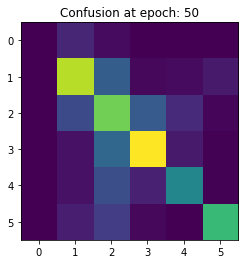

Epoch  50  is complete!
Complete in  675.3122525215149  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.32029039480074895
Validation Loss:  0.317296146585016
Train Accuracy:  0.625
Validation Accuracy:  0.6368843069873997
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 142  36   2   4   2]
 [  0  28 122  34  18   2]
 [  0   5  57 129  13   3]
 [  0   6  38   8  67   1]
 [  0  10  25   2   4  96]]


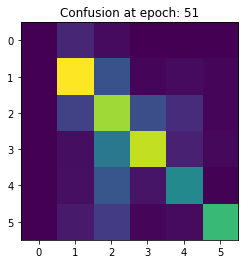

Epoch  51  is complete!
Complete in  1053.1411204338074  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.31933383996848264
Validation Loss:  0.31653488691001436
Train Accuracy:  0.6186926605504587
Validation Accuracy:  0.6345933562428407
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 146  31   3   4   2]
 [  0  39 109  39  14   3]
 [  0  10  46 138   9   4]
 [  0   9  31  13  65   2]
 [  0  16  21   3   1  96]]


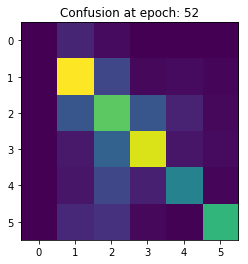

Epoch  52  is complete!
Complete in  848.3129551410675  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3186668285791663
Validation Loss:  0.3154788968354904
Train Accuracy:  0.6049311926605505
Validation Accuracy:  0.6345933562428407
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 147  31   2   4   2]
 [  0  36 122  22  22   2]
 [  0   8  59 118  21   1]
 [  0   7  37   6  69   1]
 [  0  16  21   2   0  98]]


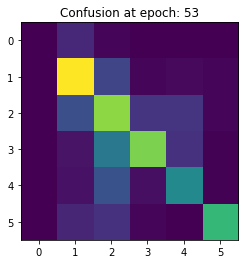

Epoch  53  is complete!
Complete in  860.4686944484711  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3178640141543074
Validation Loss:  0.315736347954253
Train Accuracy:  0.6192660550458715
Validation Accuracy:  0.5406643757159221
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 138  21   2  23   2]
 [  0  66  82  26  22   8]
 [  0  20  35 113  28  11]
 [  0  16  28   5  69   2]
 [  0  51  14   2   0  70]]


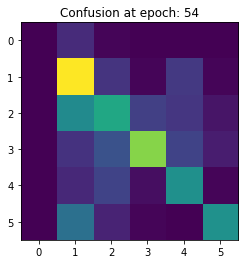

Epoch  54  is complete!
Complete in  898.7941358089447  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.31711661478706343
Validation Loss:  0.31471924809571217
Train Accuracy:  0.6138188073394495
Validation Accuracy:  0.6300114547537228
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 145  33   2   4   2]
 [  0  41 112  32  18   1]
 [  0  13  51 127  15   1]
 [  0   8  35   9  68   0]
 [  0  17  16   2   4  98]]


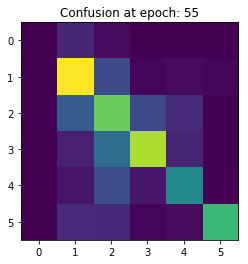

Epoch  55  is complete!
Complete in  908.3704776763916  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.316257183574037
Validation Loss:  0.3140451394874023
Train Accuracy:  0.6310206422018348
Validation Accuracy:  0.6139747995418099
Confusion matrix:
[[  0  16   3   0   0   0]
 [  0 135  32   1  16   2]
 [  0  40 105  39  19   1]
 [  0   8  46 136  17   0]
 [  0  10  32   9  68   1]
 [  0  18  16   2   9  92]]


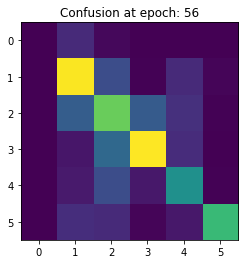

Epoch  56  is complete!
Complete in  948.4054973125458  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.31544166929126055
Validation Loss:  0.3131036541501951
Train Accuracy:  0.6267201834862385
Validation Accuracy:  0.6288659793814433
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 145  35   0   4   2]
 [  0  39 120  29  14   2]
 [  0  10  66 121   9   1]
 [  0   9  36   9  65   1]
 [  0  14  23   1   1  98]]


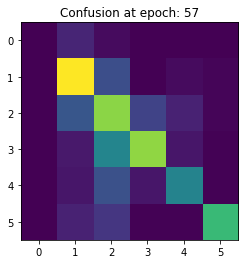

Epoch  57  is complete!
Complete in  762.9711036682129  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3146477028586062
Validation Loss:  0.31223515512809236
Train Accuracy:  0.630447247706422
Validation Accuracy:  0.6231386025200458
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 145  32   0   4   5]
 [  0  43 123  22  14   2]
 [  0  10  70 114  10   3]
 [  0  12  36   8  63   1]
 [  0  14  21   2   1  99]]


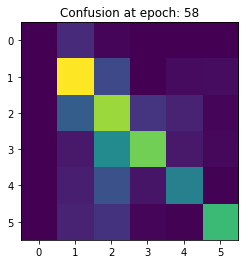

Epoch  58  is complete!
Complete in  675.154364824295  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3138701047234294
Validation Loss:  0.319159771926609
Train Accuracy:  0.6258600917431193
Validation Accuracy:  0.3837342497136312
Confusion matrix:
[[  0   3   0  16   0   0]
 [  0  77  10  93   4   2]
 [  0   4  56 125  12   7]
 [  0   6  55  80  21  45]
 [  0   2  23  48  46   1]
 [  0  24  10  27   0  76]]


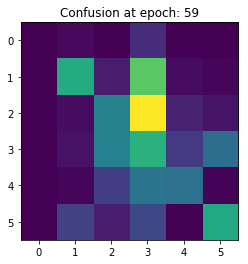

Epoch  59  is complete!
Complete in  674.4360845088959  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.31308966750884815
Validation Loss:  0.3180469617529396
Train Accuracy:  0.6287270642201835
Validation Accuracy:  0.6345933562428407
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 143  33   3   5   2]
 [  0  38 113  35  16   2]
 [  0   8  53 132  13   1]
 [  0   9  36   8  66   1]
 [  0  13  22   2   0 100]]


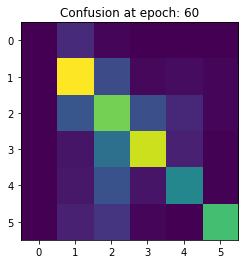

Epoch  60  is complete!
Complete in  675.580973148346  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.31229939648292776
Validation Loss:  0.31727777455727707
Train Accuracy:  0.6318807339449541
Validation Accuracy:  0.6185567010309279
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 148  31   0   5   2]
 [  0  45 118  15  23   3]
 [  0  13  65 113  14   2]
 [  0  14  39   1  65   1]
 [  0  20  16   1   4  96]]


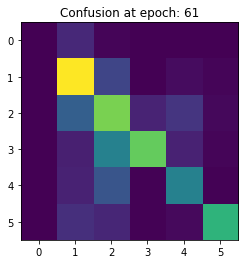

Epoch  61  is complete!
Complete in  674.383980512619  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.31181781406457915
Validation Loss:  0.3164077398475163
Train Accuracy:  0.6034977064220184
Validation Accuracy:  0.6151202749140894
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 142  30   2   5   7]
 [  0  46  97  34  26   1]
 [  0  11  45 128  22   1]
 [  0   8  36   5  71   0]
 [  0   8  23   3   4  99]]


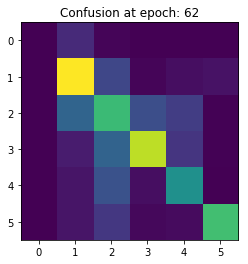

Epoch  62  is complete!
Complete in  680.8749120235443  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.31123961488160184
Validation Loss:  0.31553818982135134
Train Accuracy:  0.6155389908256881
Validation Accuracy:  0.6414662084765178
Confusion matrix:
[[  0  14   5   0   0   0]
 [  0 146  31   3   4   2]
 [  0  33 112  30  28   1]
 [  0   7  47 128  24   1]
 [  0   6  34   5  75   0]
 [  0  11  24   3   0  99]]


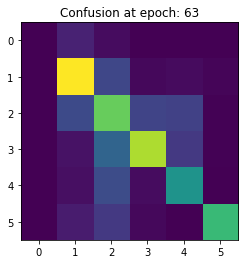

Epoch  63  is complete!
Complete in  674.1914858818054  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.31057608360879746
Validation Loss:  0.3148585739874651
Train Accuracy:  0.6330275229357798
Validation Accuracy:  0.6334478808705613
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 136  35   0  13   2]
 [  0  33 121  19  29   2]
 [  0   6  51 118  30   2]
 [  0   7  33   1  78   1]
 [  0   5  26   2   4 100]]


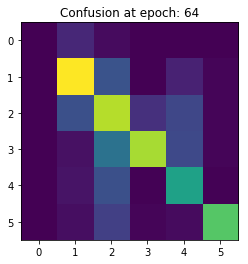

Epoch  64  is complete!
Complete in  674.4135267734528  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3099130350153734
Validation Loss:  0.31405863756325736
Train Accuracy:  0.6318807339449541
Validation Accuracy:  0.6265750286368843
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 148  27   3   4   4]
 [  0  49  88  47  16   4]
 [  0  12  39 146   9   1]
 [  0   8  28  16  66   2]
 [  0  17  15   2   4  99]]


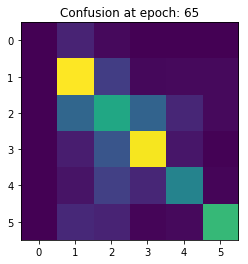

Epoch  65  is complete!
Complete in  673.3537404537201  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.30919719384852007
Validation Loss:  0.3132490621230084
Train Accuracy:  0.6318807339449541
Validation Accuracy:  0.6426116838487973
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 149  30   1   4   2]
 [  0  39 110  39  13   3]
 [  0  10  45 139  11   2]
 [  0   7  34  14  64   1]
 [  0  12  24   2   0  99]]


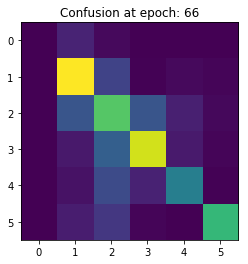

Epoch  66  is complete!
Complete in  718.3617856502533  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.30850842756718383
Validation Loss:  0.31273722602868115
Train Accuracy:  0.6330275229357798
Validation Accuracy:  0.6139747995418099
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 144  35   0   4   3]
 [  0  40 110  26  23   5]
 [  0   9  51 122  21   4]
 [  0  10  32   4  72   2]
 [  0  20  23   2   4  88]]


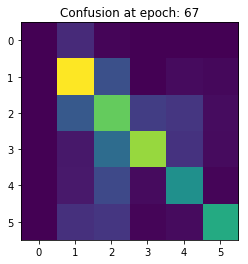

Epoch  67  is complete!
Complete in  674.2134342193604  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3079657383918113
Validation Loss:  0.3123510197222169
Train Accuracy:  0.6218463302752294
Validation Accuracy:  0.6162657502863689
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 147  32   1   4   2]
 [  0  44 106  37  15   2]
 [  0  10  47 138   4   8]
 [  0   8  33  14  63   2]
 [  0  26  21   2   4  84]]


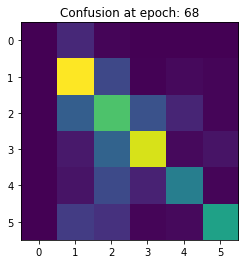

Epoch  68  is complete!
Complete in  666.3318486213684  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3073372809043111
Validation Loss:  0.31145070737859276
Train Accuracy:  0.6367545871559633
Validation Accuracy:  0.6483390607101948
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 140  40   0   4   2]
 [  0  30 122  36  15   1]
 [  0   7  50 139  10   1]
 [  0   5  39  12  64   0]
 [  0   8  24   2   2 101]]


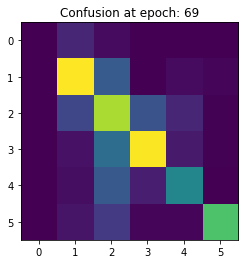

Epoch  69  is complete!
Complete in  675.1608076095581  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.30670181104265304
Validation Loss:  0.3107415191259834
Train Accuracy:  0.6318807339449541
Validation Accuracy:  0.6334478808705613
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 148  31   0   5   2]
 [  0  40 114  19  30   1]
 [  0  10  46 115  30   6]
 [  0   7  34   2  76   1]
 [  0   9  25   2   1 100]]


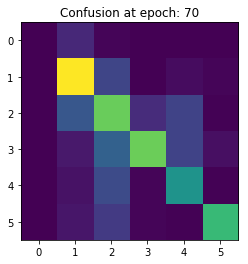

Epoch  70  is complete!
Complete in  673.8771789073944  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3060481322859908
Validation Loss:  0.3102559206013866
Train Accuracy:  0.6310206422018348
Validation Accuracy:  0.6105383734249714
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 142  37   0   5   2]
 [  0  41 107  24  29   3]
 [  0   7  53 119  20   8]
 [  0   7  35   7  69   2]
 [  0  13  24   1   3  96]]


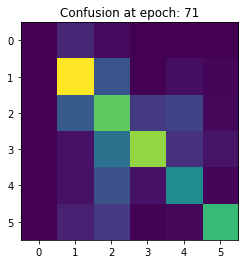

Epoch  71  is complete!
Complete in  673.1584978103638  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3054943932343651
Validation Loss:  0.3096143825825656
Train Accuracy:  0.6321674311926605
Validation Accuracy:  0.6300114547537228
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 150  29   0   4   3]
 [  0  44 113  23  20   4]
 [  0  10  58 121  15   3]
 [  0  10  32   6  69   3]
 [  0  15  20   1   4  97]]


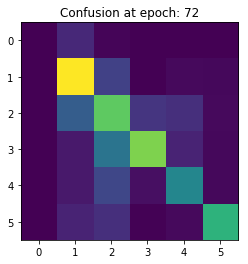

Epoch  72  is complete!
Complete in  673.7866337299347  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.30483935100437415
Validation Loss:  0.3090255181540594
Train Accuracy:  0.6427752293577982
Validation Accuracy:  0.6219931271477663
Confusion matrix:
[[  0  16   3   0   0   0]
 [  0 140  39   0   5   2]
 [  0  34 115  18  36   1]
 [  0   8  52 119  27   1]
 [  0  11  33   3  72   1]
 [  0  11  24   1   4  97]]


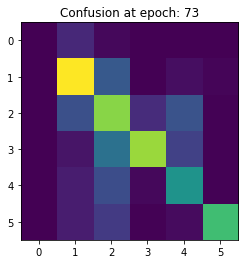

Epoch  73  is complete!
Complete in  678.5905804634094  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3042859666672068
Validation Loss:  0.30864951318650835
Train Accuracy:  0.6367545871559633
Validation Accuracy:  0.6013745704467354
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 122  39   0  23   2]
 [  0  29 130  29  14   2]
 [  0   8  61 126  10   2]
 [  0   6  38   9  66   1]
 [  0  28  26   2   0  81]]


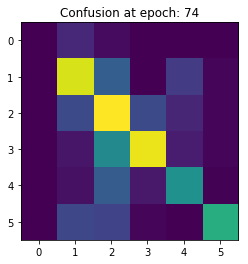

Epoch  74  is complete!
Complete in  676.7196106910706  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3036869802048533
Validation Loss:  0.3080257048657621
Train Accuracy:  0.6456422018348624
Validation Accuracy:  0.6265750286368843
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 139  37   2   4   4]
 [  0  40 109  37  17   1]
 [  0   9  47 136  14   1]
 [  0  12  30  12  66   0]
 [  0  16  17   4   3  97]]


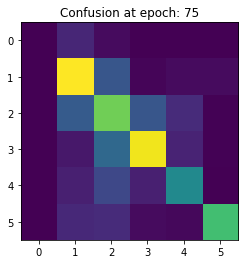

Epoch  75  is complete!
Complete in  675.2871618270874  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3030668395735727
Validation Loss:  0.3075018344262161
Train Accuracy:  0.6430619266055045
Validation Accuracy:  0.6300114547537228
Confusion matrix:
[[  0  14   5   0   0   0]
 [  0 137  36   1   5   7]
 [  0  29 107  30  33   5]
 [  0   6  43 131  25   2]
 [  0   5  33   6  75   1]
 [  0   8  22   3   4 100]]


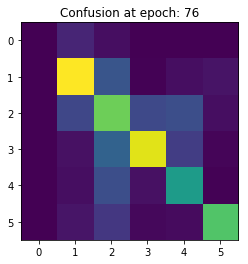

Epoch  76  is complete!
Complete in  673.8831140995026  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3024930681560211
Validation Loss:  0.3067934131622735
Train Accuracy:  0.6396215596330275
Validation Accuracy:  0.6345933562428407
Confusion matrix:
[[  0  16   3   0   0   0]
 [  0 136  42   1   5   2]
 [  0  27 116  36  23   2]
 [  0   5  51 133  17   1]
 [  0   5  36   9  69   1]
 [  0   7  27   3   0 100]]


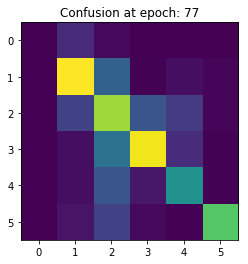

Epoch  77  is complete!
Complete in  674.2034330368042  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.30193429022414947
Validation Loss:  0.3061070275148405
Train Accuracy:  0.6407683486238532
Validation Accuracy:  0.6414662084765178
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 145  33   0   6   2]
 [  0  31 114  28  26   5]
 [  0   8  51 126  19   3]
 [  0   6  34   4  73   3]
 [  0   7  24   2   2 102]]


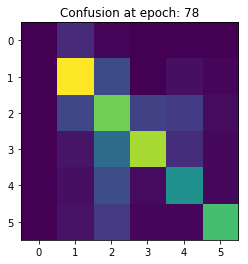

Epoch  78  is complete!
Complete in  678.3457803726196  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.301407919561016
Validation Loss:  0.3055114287863804
Train Accuracy:  0.6476490825688074
Validation Accuracy:  0.6300114547537228
Confusion matrix:
[[  0  15   4   0   0   0]
 [  0 147  32   0   4   3]
 [  0  42 106  25  28   3]
 [  0   8  54 125  19   1]
 [  0   9  33   5  72   1]
 [  0  14  18   2   3 100]]


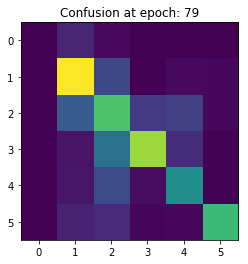

Epoch  79  is complete!
Complete in  675.535064458847  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.30083156639665753
Validation Loss:  0.30485043811534923
Train Accuracy:  0.6467889908256881
Validation Accuracy:  0.6391752577319587
Confusion matrix:
[[  0  16   2   0   1   0]
 [  0 136  39   1   5   5]
 [  0  30 116  39  17   2]
 [  0   5  48 141  12   1]
 [  0   5  36  12  66   1]
 [  0   8  25   3   2  99]]


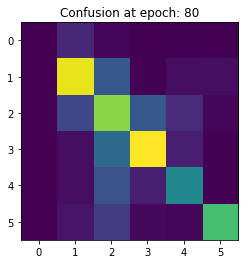

Epoch  80  is complete!
Complete in  675.5516803264618  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.3002737107416005
Validation Loss:  0.30441399063435404
Train Accuracy:  0.6505160550458715
Validation Accuracy:  0.6242840778923253
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 145  29   0   8   4]
 [  0  42  97  27  33   5]
 [  0  10  34 127  31   5]
 [  0   8  29   5  74   4]
 [  0  12  18   1   4 102]]


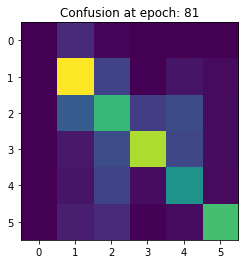

Epoch  81  is complete!
Complete in  696.4793653488159  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.2996817371392141
Validation Loss:  0.3038152738777855
Train Accuracy:  0.6556766055045872
Validation Accuracy:  0.6300114547537228
Confusion matrix:
[[  0  16   3   0   0   0]
 [  0 136  37   1   5   7]
 [  0  30 101  34  34   5]
 [  0   4  42 135  25   1]
 [  0   7  30   8  74   1]
 [  0   5  21   4   3 104]]


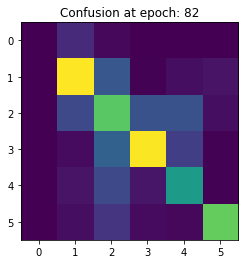

Epoch  82  is complete!
Complete in  675.8542387485504  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.299128449134564
Validation Loss:  0.30330169867094453
Train Accuracy:  0.6465022935779816
Validation Accuracy:  0.6242840778923253
Confusion matrix:
[[  0  17   2   0   0   0]
 [  0 145  32   1   5   3]
 [  0  36 101  29  35   3]
 [  0   7  50 128  21   1]
 [  0   6  34   8  72   0]
 [  0   7  23   5   3  99]]


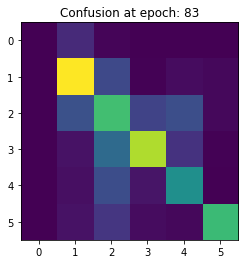

Epoch  83  is complete!
Complete in  677.1185760498047  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.29859057887405127
Validation Loss:  0.3028239213862586
Train Accuracy:  0.6467889908256881
Validation Accuracy:  0.6277205040091638
Confusion matrix:
[[  7  10   2   0   0   0]
 [  2 129  43   0   4   8]
 [  1  26 120  27  27   3]
 [  0   6  52 126  23   0]
 [  0   7  36   5  71   1]
 [  0  10  26   3   3  95]]


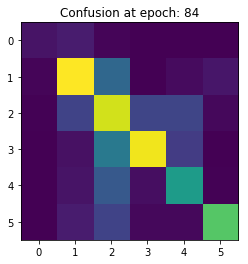

Epoch  84  is complete!
Complete in  671.7102026939392  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.2981407084369503
Validation Loss:  0.3022949008205772
Train Accuracy:  0.6396215596330275
Validation Accuracy:  0.6437571592210768
Confusion matrix:
[[  5  10   4   0   0   0]
 [  1 143  34   1   4   3]
 [  1  34 119  33  14   3]
 [  0   8  58 124  15   2]
 [  0   7  34  10  67   2]
 [  0   9  21   2   1 104]]


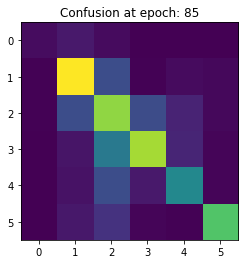

Epoch  85  is complete!
Complete in  673.8288798332214  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.29759142615677225
Validation Loss:  0.30326642738352905
Train Accuracy:  0.6539564220183486
Validation Accuracy:  0.5292096219931272
Confusion matrix:
[[  3  12   4   0   0   0]
 [  1 122  36   0  23   4]
 [  1  32 108  18  35  10]
 [  0   7  47  74  29  50]
 [  0   8  33   5  72   2]
 [  0  28  23   2   1  83]]


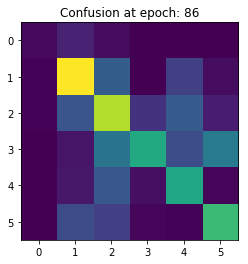

Epoch  86  is complete!
Complete in  673.1177895069122  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.2970641572726364
Validation Loss:  0.3028237857723873
Train Accuracy:  0.6568233944954128
Validation Accuracy:  0.6357388316151202
Confusion matrix:
[[  3  13   3   0   0   0]
 [  1 145  31   0   4   5]
 [  1  40 101  34  25   3]
 [  0  10  47 132  16   2]
 [  0   9  29   7  72   3]
 [  0  11  18   2   4 102]]


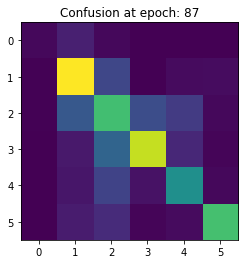

Epoch  87  is complete!
Complete in  674.1971755027771  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.2965668648262481
Validation Loss:  0.302390264453449
Train Accuracy:  0.6442087155963303
Validation Accuracy:  0.6288659793814433
Confusion matrix:
[[  7   8   4   0   0   0]
 [  2 138  38   0   5   3]
 [  2  37  99  27  36   3]
 [  0   8  47 123  28   1]
 [  0   6  26   6  81   1]
 [  0   5  24   2   5 101]]


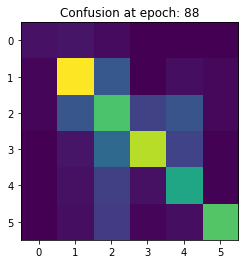

Epoch  88  is complete!
Complete in  673.7803587913513  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.29603287392744787
Validation Loss:  0.30186613383633354
Train Accuracy:  0.6591169724770642
Validation Accuracy:  0.6414662084765178
Confusion matrix:
[[  3  12   4   0   0   0]
 [  1 140  37   0   4   4]
 [  1  33 114  24  26   6]
 [  0   8  49 128  19   3]
 [  0   7  32   7  72   2]
 [  0  10  20   2   2 103]]


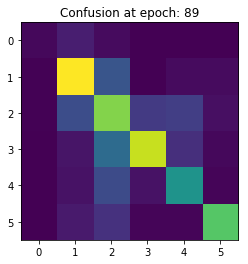

Epoch  89  is complete!
Complete in  678.8519468307495  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.29548213627931147
Validation Loss:  0.3013872997503175
Train Accuracy:  0.6585435779816514
Validation Accuracy:  0.6380297823596792
Confusion matrix:
[[  7   8   4   0   0   0]
 [  3 140  35   1   4   3]
 [  2  33 105  33  22   9]
 [  1  12  45 128  18   3]
 [  0   9  27   7  72   5]
 [  0   7  21   2   2 105]]


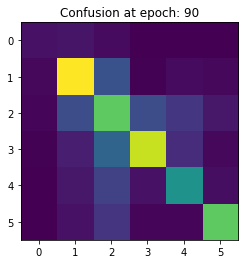

Epoch  90  is complete!
Complete in  673.8533806800842  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.2949781926051147
Validation Loss:  0.3008486478505719
Train Accuracy:  0.6565366972477065
Validation Accuracy:  0.6391752577319587
Confusion matrix:
[[  7   8   4   0   0   0]
 [  3 140  33   1   4   5]
 [  2  34 105  39  17   7]
 [  0   8  50 136  12   1]
 [  0  10  31  11  67   1]
 [  0   7  23   3   1 103]]


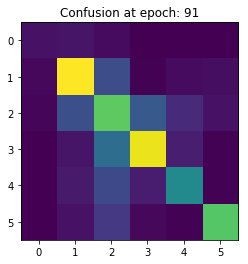

Epoch  91  is complete!
Complete in  674.152360200882  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.29451309744812976
Validation Loss:  0.3004062310808305
Train Accuracy:  0.6585435779816514
Validation Accuracy:  0.6334478808705613
Confusion matrix:
[[  7   8   4   0   0   0]
 [  1 142  34   1   5   3]
 [  2  31  92  36  36   7]
 [  0  10  36 132  27   2]
 [  0   9  22   5  82   2]
 [  1  11  24   2   1  98]]


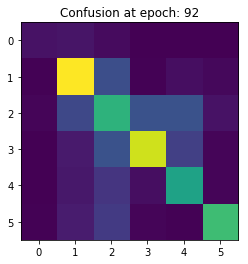

Epoch  92  is complete!
Complete in  672.8892378807068  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.2940722839284851
Validation Loss:  0.30059755117611847
Train Accuracy:  0.654243119266055
Validation Accuracy:  0.5670103092783505
Confusion matrix:
[[  3  14   2   0   0   0]
 [  1 143  34   0   4   4]
 [  1  35 102  29  16  21]
 [  0  12  43  91  15  46]
 [  0   7  30   8  69   6]
 [  0  31  17   2   0  87]]


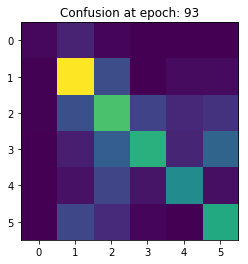

Epoch  93  is complete!
Complete in  673.7649283409119  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.29380895216612746
Validation Loss:  0.30015356178817443
Train Accuracy:  0.6313073394495413
Validation Accuracy:  0.6391752577319587
Confusion matrix:
[[  7   9   3   0   0   0]
 [  1 139  39   0   5   2]
 [  1  31 114  29  24   5]
 [  0   9  48 127  21   2]
 [  0   5  37   5  72   1]
 [  0   9  22   3   4  99]]


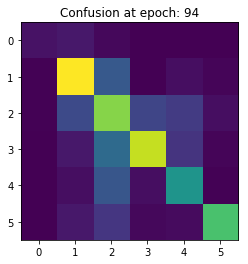

Epoch  94  is complete!
Complete in  678.4679808616638  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.29334821578318293
Validation Loss:  0.29974978515813916
Train Accuracy:  0.6596903669724771
Validation Accuracy:  0.6288659793814433
Confusion matrix:
[[  3  13   3   0   0   0]
 [  2 142  36   0   4   2]
 [  1  37 111  26  22   7]
 [  0  10  52 123  21   1]
 [  0  12  29   3  73   3]
 [  0  12  24   3   1  97]]


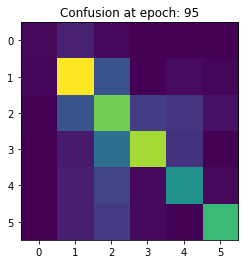

Epoch  95  is complete!
Complete in  672.8071703910828  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.2928723504665057
Validation Loss:  0.2992542068861468
Train Accuracy:  0.6625573394495413
Validation Accuracy:  0.6471935853379153
Confusion matrix:
[[  8   7   4   0   0   0]
 [  5 135  40   0   4   2]
 [  2  31 120  35  10   6]
 [  0   7  53 136  10   1]
 [  0   5  37  10  66   2]
 [  0   9  23   4   1 100]]


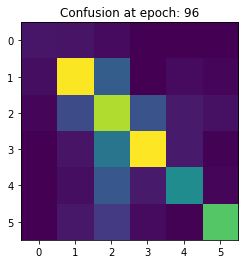

Epoch  96  is complete!
Complete in  675.9372832775116  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.29249800278628113
Validation Loss:  0.29892649920308917
Train Accuracy:  0.6573967889908257
Validation Accuracy:  0.6368843069873997
Confusion matrix:
[[  3  12   4   0   0   0]
 [  2 140  37   0   4   3]
 [  1  35 106  45  11   6]
 [  0  12  44 141  10   0]
 [  0   7  29  14  67   3]
 [  1  13  21   3   0  99]]


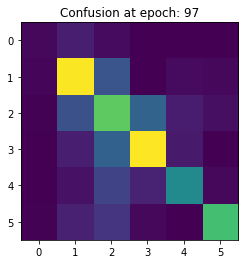

Epoch  97  is complete!
Complete in  672.7540428638458  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.29200120477487
Validation Loss:  0.2985968468549698
Train Accuracy:  0.6608371559633027
Validation Accuracy:  0.6277205040091638
Confusion matrix:
[[  7  10   2   0   0   0]
 [  2 139  37   0   4   4]
 [  2  33  95  35  31   8]
 [  0   9  38 136  24   0]
 [  0   8  32   8  70   2]
 [  0   9  17   5   5 101]]


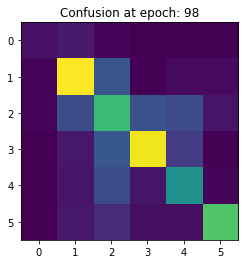

Epoch  98  is complete!
Complete in  672.942699432373  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.2915403765738364
Validation Loss:  0.29819274334127305
Train Accuracy:  0.6576834862385321
Validation Accuracy:  0.6242840778923253
Confusion matrix:
[[  7   8   3   0   1   0]
 [  5 137  36   0   4   4]
 [  2  33  98  30  32   9]
 [  0  12  34 125  28   8]
 [  0   9  27   8  72   4]
 [  0  10  18   3   0 106]]


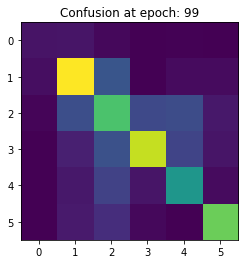

Epoch  99  is complete!
Complete in  708.1955795288086  seconds


Training document  500  /  3488 ...
Training document  1000  /  3488 ...
Training document  1500  /  3488 ...
Training document  2000  /  3488 ...
Training document  2500  /  3488 ...
Training document  3000  /  3488 ...
Validating document  500  /  873 ...

Train Loss:  0.2910837039656027
Validation Loss:  0.29772937973153396
Train Accuracy:  0.6596903669724771
Validation Accuracy:  0.6345933562428407
Confusion matrix:
[[  7   8   4   0   0   0]
 [  3 138  36   1   4   4]
 [  1  32  97  35  32   7]
 [  0   7  40 134  23   3]
 [  0   7  29   7  74   3]
 [  0  10  18   4   1 104]]


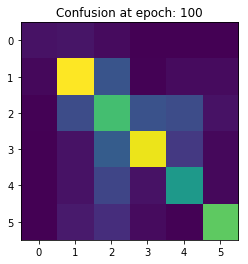

Saving the model at epoch:  100  as  genlstm_300n_3l_100
Epoch  100  is complete!
Complete in  798.5785250663757  seconds




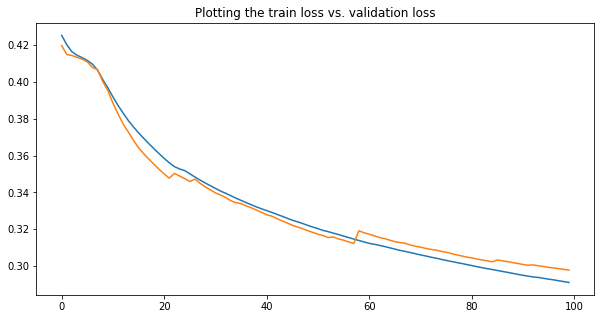

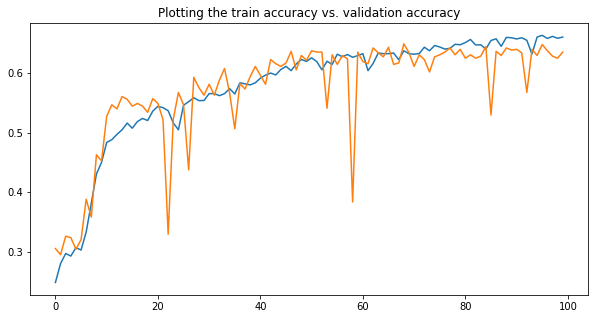

In [390]:
# training a model from scratch

# setting up the train, validation and test sets
#tr, va, te = split_data(clean_5500['text'], onehot_5500, (0.2, 0.2))

# initializing a new model
#mod1 = set_model(300, 3, 0.7)

# saving the initialized model to be compared later in task 2
#saving(mod1, 'ques_lstm/init_300n_3l')

# training and validating the model
#tr_mod1, res1 = train_valid(mod1, tr, va, 100, 5, 'genlstm_300n_3l_')

In [392]:
## loading the recently trained model

# setting a sample structure before loading a trained model
mod0 = set_model(300, 3, 0.7)

# directly load the trained lstm model
trained_lstm = loading(mod0, 'ques_lstm/genlstm_300n_3l_100')

Model Architecture: 
gensim_lstm(
  (lstm): LSTM(100, 300, num_layers=3, dropout=0.7)
  (dense): Linear(in_features=600, out_features=6, bias=True)
  (sigm): Sigmoid()
)


# 7. Testing the trained model

In [415]:
def test_model(model, test):
    '''
    model: the trained model that will then be tested
    test: the testing dataset (test[0] is input test[1] is output)
    '''
    
    # loss function
    loss_fn = torch.nn.BCELoss()
    
    # setting model to train mode
    model.eval()
    
    predict_class, actual_class = [], []
    test_losses, all_class = [], []
    
    # iterating through the training data
    for vec in range(len(test[0])):

        # initializing the hidden layer
        hid = model.init_hidden()

        # setting up the input and output
        inp = text_tensor(test[0].iloc[vec], w2v_5500_vectors)
        out = torch.tensor(test[1].iloc[vec], dtype=torch.float).reshape(1, -1)

        pred = model(inp, hid)

        # calculating the loss
        loss = loss_fn(pred, out)
        test_losses.append(loss.item())

        actual_class.append(torch.argmax(out))
        predict_class.append(torch.argmax(pred).detach())
        all_class.append(pred.detach())
        
        op = ""
        if actual_class[-1] == predict_class[-1]:
            op = 'Y'
        else:
            op = 'N'
            
        print(vec, " : ", "actual - ", te[1].columns[actual_class[-1].item()], 
              " predict - ", te[1].columns[predict_class[-1].item()], "grade: ", op)
        
    
    accuracy = sk.metrics.accuracy_score(actual_class, predict_class)
    confusion = sk.metrics.confusion_matrix(actual_class, predict_class)
    
    print("\nAccuracy: ", accuracy)
    print("Confusion matrix:")
    print(confusion)

    title = "Confusion visualization"
    plt.title(title)
    plt.imshow(confusion)
    plt.show()
    
    return all_class

C:\Users\sunny\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
C:\Users\sunny\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
C:\Users\sunny\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0  :  actual -  ('NUM',)  predict -  ('NUM',) grade:  Y
1  :  actual -  ('ENTY',)  predict -  ('ABBR',) grade:  N
2  :  actual -  ('LOC',)  predict -  ('LOC',) grade:  Y
3  :  actual -  ('DESC',)  predict -  ('DESC',) grade:  Y
4  :  actual -  ('DESC',)  predict -  ('ENTY',) grade:  N
5

C:\Users\sunny\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  :  actual -  ('HUM',)  predict -  ('HUM',) grade:  Y
6  :  actual -  ('ENTY',)  predict -  ('ENTY',) grade:  Y
7  :  actual -  ('HUM',)  predict -  ('HUM',) grade:  Y
8  :  actual -  ('HUM',)  predict -  ('HUM',) grade:  Y
9  :  actual -  ('LOC',)  predict -  ('LOC',) grade:  Y
10  :  actual -  ('HUM',)  predict -  ('HUM',) grade:  Y
11  :  actual -  ('DESC',)  predict -  ('DESC',) grade:  Y
12  :  actual -  ('NUM',)  predict -  ('ENTY',) grade:  N
13  :  actual -  ('ENTY',)  predict -  ('ENTY',) grade:  Y
14  :  actual -  ('HUM',)  predict -  ('HUM',) grade:  Y
15  :  actual -  ('HUM',)  predict -  ('ENTY',) grade:  N
16  :  actual -  ('DESC',)  predict -  ('ENTY',) grade:  N
17  :  actual -  ('NUM',)  predict -  ('DESC',) grade:  N
18  :  actual -  ('NUM',)  predict -  ('NUM',) grade:  Y
19  :  actual -  ('DESC',)  predict -  ('ENTY',) grade:  N
20  :  actual -  ('NUM',)  predict -  ('NUM',) grade:  Y
21  :  actual -  ('ENTY',)  predict -  ('ENTY',) grade:  Y
22  :  actual -  ('ENT

150  :  actual -  ('HUM',)  predict -  ('LOC',) grade:  N
151  :  actual -  ('LOC',)  predict -  ('ENTY',) grade:  N
152  :  actual -  ('DESC',)  predict -  ('ENTY',) grade:  N
153  :  actual -  ('HUM',)  predict -  ('ENTY',) grade:  N
154  :  actual -  ('DESC',)  predict -  ('DESC',) grade:  Y
155  :  actual -  ('ENTY',)  predict -  ('LOC',) grade:  N
156  :  actual -  ('HUM',)  predict -  ('HUM',) grade:  Y
157  :  actual -  ('ENTY',)  predict -  ('ENTY',) grade:  Y
158  :  actual -  ('ENTY',)  predict -  ('ENTY',) grade:  Y
159  :  actual -  ('ENTY',)  predict -  ('ENTY',) grade:  Y
160  :  actual -  ('ABBR',)  predict -  ('ENTY',) grade:  N
161  :  actual -  ('NUM',)  predict -  ('NUM',) grade:  Y
162  :  actual -  ('ENTY',)  predict -  ('LOC',) grade:  N
163  :  actual -  ('LOC',)  predict -  ('LOC',) grade:  Y
164  :  actual -  ('HUM',)  predict -  ('LOC',) grade:  N
165  :  actual -  ('HUM',)  predict -  ('HUM',) grade:  Y
166  :  actual -  ('ENTY',)  predict -  ('ENTY',) grade:

292  :  actual -  ('DESC',)  predict -  ('DESC',) grade:  Y
293  :  actual -  ('LOC',)  predict -  ('LOC',) grade:  Y
294  :  actual -  ('LOC',)  predict -  ('ENTY',) grade:  N
295  :  actual -  ('HUM',)  predict -  ('HUM',) grade:  Y
296  :  actual -  ('LOC',)  predict -  ('LOC',) grade:  Y
297  :  actual -  ('ENTY',)  predict -  ('ENTY',) grade:  Y
298  :  actual -  ('LOC',)  predict -  ('LOC',) grade:  Y
299  :  actual -  ('NUM',)  predict -  ('ENTY',) grade:  N
300  :  actual -  ('DESC',)  predict -  ('DESC',) grade:  Y
301  :  actual -  ('DESC',)  predict -  ('DESC',) grade:  Y
302  :  actual -  ('DESC',)  predict -  ('DESC',) grade:  Y
303  :  actual -  ('LOC',)  predict -  ('LOC',) grade:  Y
304  :  actual -  ('DESC',)  predict -  ('DESC',) grade:  Y
305  :  actual -  ('DESC',)  predict -  ('ENTY',) grade:  N
306  :  actual -  ('DESC',)  predict -  ('DESC',) grade:  Y
307  :  actual -  ('LOC',)  predict -  ('LOC',) grade:  Y
308  :  actual -  ('HUM',)  predict -  ('ENTY',) grade

435  :  actual -  ('NUM',)  predict -  ('ENTY',) grade:  N
436  :  actual -  ('HUM',)  predict -  ('HUM',) grade:  Y
437  :  actual -  ('LOC',)  predict -  ('LOC',) grade:  Y
438  :  actual -  ('ENTY',)  predict -  ('LOC',) grade:  N
439  :  actual -  ('ENTY',)  predict -  ('LOC',) grade:  N
440  :  actual -  ('HUM',)  predict -  ('HUM',) grade:  Y
441  :  actual -  ('DESC',)  predict -  ('DESC',) grade:  Y
442  :  actual -  ('NUM',)  predict -  ('NUM',) grade:  Y
443  :  actual -  ('DESC',)  predict -  ('DESC',) grade:  Y
444  :  actual -  ('ENTY',)  predict -  ('HUM',) grade:  N
445  :  actual -  ('HUM',)  predict -  ('HUM',) grade:  Y
446  :  actual -  ('DESC',)  predict -  ('ENTY',) grade:  N
447  :  actual -  ('NUM',)  predict -  ('NUM',) grade:  Y
448  :  actual -  ('ENTY',)  predict -  ('DESC',) grade:  N
449  :  actual -  ('LOC',)  predict -  ('ENTY',) grade:  N
450  :  actual -  ('DESC',)  predict -  ('DESC',) grade:  Y
451  :  actual -  ('ENTY',)  predict -  ('HUM',) grade:  

576  :  actual -  ('DESC',)  predict -  ('DESC',) grade:  Y
577  :  actual -  ('HUM',)  predict -  ('HUM',) grade:  Y
578  :  actual -  ('LOC',)  predict -  ('ENTY',) grade:  N
579  :  actual -  ('DESC',)  predict -  ('DESC',) grade:  Y
580  :  actual -  ('DESC',)  predict -  ('DESC',) grade:  Y
581  :  actual -  ('HUM',)  predict -  ('NUM',) grade:  N
582  :  actual -  ('HUM',)  predict -  ('HUM',) grade:  Y
583  :  actual -  ('LOC',)  predict -  ('LOC',) grade:  Y
584  :  actual -  ('LOC',)  predict -  ('ENTY',) grade:  N
585  :  actual -  ('NUM',)  predict -  ('ENTY',) grade:  N
586  :  actual -  ('LOC',)  predict -  ('LOC',) grade:  Y
587  :  actual -  ('ENTY',)  predict -  ('HUM',) grade:  N
588  :  actual -  ('DESC',)  predict -  ('DESC',) grade:  Y
589  :  actual -  ('LOC',)  predict -  ('LOC',) grade:  Y
590  :  actual -  ('DESC',)  predict -  ('DESC',) grade:  Y
591  :  actual -  ('LOC',)  predict -  ('DESC',) grade:  N
592  :  actual -  ('HUM',)  predict -  ('HUM',) grade:  Y

718  :  actual -  ('NUM',)  predict -  ('NUM',) grade:  Y
719  :  actual -  ('HUM',)  predict -  ('ENTY',) grade:  N
720  :  actual -  ('ENTY',)  predict -  ('ENTY',) grade:  Y
721  :  actual -  ('DESC',)  predict -  ('ENTY',) grade:  N
722  :  actual -  ('ENTY',)  predict -  ('ENTY',) grade:  Y
723  :  actual -  ('ENTY',)  predict -  ('HUM',) grade:  N
724  :  actual -  ('LOC',)  predict -  ('HUM',) grade:  N
725  :  actual -  ('HUM',)  predict -  ('ENTY',) grade:  N
726  :  actual -  ('HUM',)  predict -  ('HUM',) grade:  Y
727  :  actual -  ('ENTY',)  predict -  ('ENTY',) grade:  Y
728  :  actual -  ('ENTY',)  predict -  ('LOC',) grade:  N
729  :  actual -  ('LOC',)  predict -  ('DESC',) grade:  N
730  :  actual -  ('HUM',)  predict -  ('HUM',) grade:  Y
731  :  actual -  ('DESC',)  predict -  ('NUM',) grade:  N
732  :  actual -  ('HUM',)  predict -  ('HUM',) grade:  Y
733  :  actual -  ('DESC',)  predict -  ('ABBR',) grade:  N
734  :  actual -  ('DESC',)  predict -  ('DESC',) grade:

858  :  actual -  ('NUM',)  predict -  ('ENTY',) grade:  N
859  :  actual -  ('NUM',)  predict -  ('NUM',) grade:  Y
860  :  actual -  ('DESC',)  predict -  ('DESC',) grade:  Y
861  :  actual -  ('HUM',)  predict -  ('HUM',) grade:  Y
862  :  actual -  ('HUM',)  predict -  ('ENTY',) grade:  N
863  :  actual -  ('ABBR',)  predict -  ('ENTY',) grade:  N
864  :  actual -  ('DESC',)  predict -  ('DESC',) grade:  Y
865  :  actual -  ('DESC',)  predict -  ('DESC',) grade:  Y
866  :  actual -  ('LOC',)  predict -  ('LOC',) grade:  Y
867  :  actual -  ('ENTY',)  predict -  ('HUM',) grade:  N
868  :  actual -  ('DESC',)  predict -  ('LOC',) grade:  N
869  :  actual -  ('HUM',)  predict -  ('ENTY',) grade:  N
870  :  actual -  ('NUM',)  predict -  ('NUM',) grade:  Y
871  :  actual -  ('ABBR',)  predict -  ('ABBR',) grade:  Y
872  :  actual -  ('LOC',)  predict -  ('LOC',) grade:  Y
873  :  actual -  ('HUM',)  predict -  ('ENTY',) grade:  N
874  :  actual -  ('DESC',)  predict -  ('DESC',) grade:

998  :  actual -  ('HUM',)  predict -  ('HUM',) grade:  Y
999  :  actual -  ('LOC',)  predict -  ('ENTY',) grade:  N
1000  :  actual -  ('ENTY',)  predict -  ('ENTY',) grade:  Y
1001  :  actual -  ('DESC',)  predict -  ('ENTY',) grade:  N
1002  :  actual -  ('ENTY',)  predict -  ('HUM',) grade:  N
1003  :  actual -  ('ENTY',)  predict -  ('NUM',) grade:  N
1004  :  actual -  ('HUM',)  predict -  ('HUM',) grade:  Y
1005  :  actual -  ('ENTY',)  predict -  ('ENTY',) grade:  Y
1006  :  actual -  ('HUM',)  predict -  ('DESC',) grade:  N
1007  :  actual -  ('DESC',)  predict -  ('DESC',) grade:  Y
1008  :  actual -  ('LOC',)  predict -  ('LOC',) grade:  Y
1009  :  actual -  ('HUM',)  predict -  ('LOC',) grade:  N
1010  :  actual -  ('HUM',)  predict -  ('HUM',) grade:  Y
1011  :  actual -  ('NUM',)  predict -  ('DESC',) grade:  N
1012  :  actual -  ('ENTY',)  predict -  ('LOC',) grade:  N
1013  :  actual -  ('DESC',)  predict -  ('ENTY',) grade:  N
1014  :  actual -  ('DESC',)  predict -  (

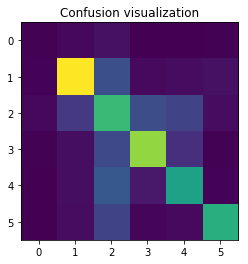

In [416]:
# testing the 1st model genlstm_200n_2l
mod1_test_results = test_model(trained_lstm, te)